# Analyzing New Testament Similarity using tf-idf, Cosine Similarity, and Principal Component Analysis

## Introduction

All of the analysis in this notebook is on the [data provided here](https://github.com/morphgnt/sblgnt). The morphological parsing and lemmatization is provided under a [CC-BY-SA License](http://creativecommons.org/licenses/by-sa/3.0/) while the SBLGNT text is subject to the [SBLGNT EULA](http://sblgnt.com/license/).

Using the text of the Greek New Testament we will analyze the similarity of books with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term frequency-inverse document frequency).

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.set_printoptions(precision=2)

%matplotlib inline

In [2]:
directory = '../sblgnt'

books = []
dfs = []
for filename in os.scandir(directory):
    if filename.is_file() and filename.name.endswith('.txt'):
        dfs.append(pd.read_csv(filename.path, header=None, delim_whitespace=True))
        books.append(filename.name.split('-')[1])

Above we imported the necessary libraries and then used pandas to read in the morphological data to pandas dataframes so that we can easily access them.

The feature that we are interested in from the data is the lemma of each word, found in the sixth column. The lemma is like a normalized form of each word. For example, in English, the lemma of "sing", "sings", "singing", and "sang" would all be just "sing", so that they all count as the same word. This is even more important in Greek since words change their spelling based on the other words around them much more often, including proper names.

Here below we have `dfs`, which is a list of 27 dataframes, one for each book in the New Testament, and `dfs[0]` refers to the first book which is Matthew. We are then accessing the sixth column of the dataframe which contains the lemmatized form of each word in the book of Matthew.

In [3]:
dfs[0][6]

0           βίβλος
1          γένεσις
2           Ἰησοῦς
3          Χριστός
4             υἱός
           ...    
18324          ἕως
18325            ὁ
18326    συντέλεια
18327            ὁ
18328         αἰών
Name: 6, Length: 18329, dtype: object

Now we go through every Greek word that appears in the New Testament and record how often it appears within each book (term frequency) and also record how many books it appears in (document frequency).

In [4]:
lemma_column = 6

words = []
tf = []
df = {}

for doc in dfs:
    # create term frequency dictionary for this document
    tf_dic = {}
    for word in doc[lemma_column]:
        if word in df:
            # previously encountered word in corpus
            if word in tf_dic:
                # previously encountered word in document
                tf_dic[word]["count"] += 1
            else:
                # first occurrence in document
                tf_dic[word] = { "index": df[word]["index"], "count": 1 }
                df[word]["count"] += 1
        else:
            # first occurrence in corpus
            words.append(word)
            tf_dic[word] = { "index": len(words) - 1, "count": 1 }
            df[word] = { "index": len(words) - 1, "count": 1 }
    tf.append(tf_dic)

We now have a list of every unique word that appears in the Greek New Testament, and see that according to this data there are 5,461 unique words.

For example, the 1,477th word in our list is ἀγάπη (agape) which means love.

In [5]:
len(words)

5461

In [6]:
words[1476]

'ἀγάπη'

We now compute the tf-idf values for each word and book in the New Testament. We store this as a 5461 x 27 matrix of values, where each of the rows represents a word and each column represents a book. You can find the formula for computing the tf-idf score on the Wikipedia page.

In [7]:
vec = np.zeros((len(words), len(dfs))) # (5461, 27) matrix of tf-idf vectors

for i in range(vec.shape[0]):
    word = words[i]
    for j in range(vec.shape[1]):
        if word in tf[j]:
            vec[i][j] = (tf[j][word]["count"] / dfs[j].shape[0]) * np.log(len(dfs) / df[word]["count"]) # tf * idf
        else:
            vec[i][j] = 0

Since we know that our 1,477th word was ἀγάπη, we can take a look at the 1,477th row of `vec` and this represents the tf-idf score for ἀγάπη for each of the 27 books of the Bible. We can make a bar chart of these values to see that ἀγάπη seems to be relatively more important in Philemon, 1 John, 2 John, and Jude, compared to many of the other books.

In [8]:
vec[1476]

array([6.43e-06, 0.00e+00, 6.06e-06, 5.34e-05, 0.00e+00, 1.50e-04,
       2.42e-04, 2.37e-04, 1.59e-04, 4.88e-04, 2.90e-04, 3.73e-04,
       4.00e-04, 4.31e-04, 3.70e-04, 3.81e-04, 1.79e-04, 1.06e-03,
       4.77e-05, 0.00e+00, 2.11e-04, 1.07e-04, 9.92e-04, 9.61e-04,
       5.38e-04, 7.70e-04, 2.40e-05])

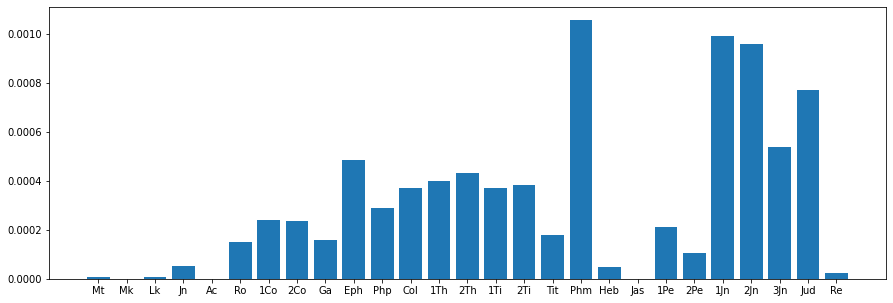

In [9]:
plt.figure(figsize=(15, 5))
plt.bar(books, vec[1476])
plt.show()

Although it's much harder to visualize, we could also look at individual columns of `vec`. For example the first column of `vec` represents how important each of our 5,461 words are within the book of Matthew.

In [10]:
vec[:,0]

array([8.21e-05, 2.40e-04, 3.13e-04, ..., 0.00e+00, 0.00e+00, 0.00e+00])

The three dots above are indicating that we cannot see the entire vector because there are 5,461 entries, so instead we only see the first few and the last few.

## Cosine Similarity

Now that we have done tf-idf, we have a vector that represents each book of the New Testament (each of the 27 columns of `vec`). The problem is that these vectors live in a very high dimensional space (5,461 dimensions) and so they are difficult to work with. We cannot visualize a space with that many dimensions and so we cannot directly "see" the data in a meaningful way.

One solution to this problem is [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity), which gives a value between 1 and -1 based on how similar or dissimilar two vectors are. If two vectors are pointing in the same direction, they get a score of 1, if two vectors are perpendicular, they get a score of 0, and if two vectors are pointing in exact opposite directions then they get a score of -1. Since the values of our tf-idf vectors are all positive, their cosine similarity will never be less than 0, so the scores that we see will be between 0 and 1.

With cosine similarity it doesn't matter how many dimensions our vectors are, in the end we will get a single score for every pair of vectors.

In [11]:
vec_norm = vec / np.linalg.norm(vec, axis=0)
similarity = np.matmul(vec_norm.T, vec_norm)
similarity.shape

(27, 27)

The `similarity` variable holds a 27 x 27 symmetric matrix that stores the cosine similarity between each pair of our tf-idf vectors for each book of the New Testament. The diagonal entries of this matrix are all 1, since every book is exactly the same as itself. The entry in the first row and second column tells me the cosine similarity between Matthew and Mark. Similarly, the entry in the second row and first column tells me the cosine similarity between Mark and Matthew. These numbers are exactly the same, which is why the matrix is symmetric.

Here is the top-left 4 x 4 submatrix of `similarity`, which shows the cosine similarity between the four gospels. You can see that Matthew, Mark, and Luke are all more similar to each other (0.74, 0.72, 0.68) than John is to any of them (0.62, 0.61, 0.56). This is perhaps a good sign that something meaningful is being measured here since Matthew, Mark, and Luke are often given the subcategory of synoptic gospels separate from John. Whether that is actually what is being measured is difficult to determine.

In [12]:
similarity[:4,:4]

array([[1.  , 0.74, 0.72, 0.62],
       [0.74, 1.  , 0.68, 0.61],
       [0.72, 0.68, 1.  , 0.56],
       [0.62, 0.61, 0.56, 1.  ]])

It's difficult to show the full 27 x 27 matrix so below I've enumerated for each book the top five books based on cosine similarity to that book.

This is pretty encouraging because we see a lot of results that we would expect. The most similar book to Acts is Luke. Romans and Galatians are most similar to each other. 1 Thessalonians and 2 Thessalonians are most similar to each other. Colossians and Ephesians are most similar to each other.

There are however some strange results, such as Hebrews and Revelation being most similar to the gospels and Acts (but not each other). We also have James and Romans being quite similar, probably because of their frequent use of the words faith and works, even though they are talking about them in different ways.

This reveals one of the limitations of tf-idf, which is that it only considers the presence of words within a book and not the order of words or anything regarding their context. This means that two sentences "faith is good" and "faith is not good" would be marked as very similar because they use similar words, ignoring that the sentences have complete opposite meanings.

Notice also that 3 John, while it is most similar to 2 John, it only has a 0.09 similarity score with it. This means that it is in fact not very similar to 2 John and is not similar to any of the other books.

In [13]:
for i, book in enumerate(books):
    print(book, ": ", sep='', end='')
    args = np.argsort(similarity[i])
    for j in range(4):
        print(books[args[-j-2]], f"({similarity[i][args[-j-2]]:.2f}), ", end='')
    print(books[args[-6]], f"({similarity[i][args[-6]]:.2f})")

Mt: Mk (0.74), Lk (0.72), Jn (0.62), Ac (0.39), Re (0.25)
Mk: Mt (0.74), Lk (0.68), Jn (0.61), Ac (0.38), Re (0.21)
Lk: Mt (0.72), Mk (0.68), Jn (0.56), Ac (0.48), Re (0.25)
Jn: Mt (0.62), Mk (0.61), Lk (0.56), Ac (0.38), 1Jn (0.22)
Ac: Lk (0.48), Mt (0.39), Jn (0.38), Mk (0.38), Heb (0.22)
Ro: Ga (0.43), 1Co (0.31), 2Co (0.24), Jas (0.22), Heb (0.22)
1Co: Ro (0.31), Lk (0.25), Eph (0.23), Mt (0.22), 2Co (0.22)
2Co: Ro (0.24), 1Co (0.22), Php (0.21), 1Th (0.17), Eph (0.14)
Ga: Ro (0.43), 1Co (0.21), Ac (0.18), Jas (0.16), Heb (0.16)
Eph: Col (0.30), 1Co (0.23), Ro (0.21), 2Co (0.14), 1Th (0.14)
Php: 2Co (0.21), Ro (0.20), 1Co (0.17), 1Th (0.15), Eph (0.14)
Col: Eph (0.30), 1Co (0.20), Ro (0.17), Phm (0.14), 2Co (0.14)
1Th: 2Th (0.19), 2Co (0.17), 1Co (0.17), Ro (0.15), Php (0.15)
2Th: 1Th (0.19), 1Co (0.15), 2Co (0.13), Eph (0.11), Ro (0.11)
1Ti: Tit (0.24), 2Ti (0.16), 1Co (0.12), Ro (0.11), Lk (0.11)
2Ti: 1Ti (0.16), Tit (0.14), Ro (0.11), Ac (0.10), Lk (0.09)
Tit: 1Ti (0.24), 2Ti (0

## Principal Component Analysis

Cosine similarity is an effective way of conceptualizing the similarity between vectors in high-dimensional spaces, but it still fails to allow us to visualize the data in a meaningful way. It showed that both Hebrews and Revelation are similar to the gospels and Acts but not necessarily to each other, but what does that actually look like on a graph?

One way to visualize high-dimensional data is via dimensionality reduction. We will purposefully ignore most of the dimensions to look at only a few. For example, we could look at just the ἀγάπη (love) dimension and the πίστις (faith) dimension.

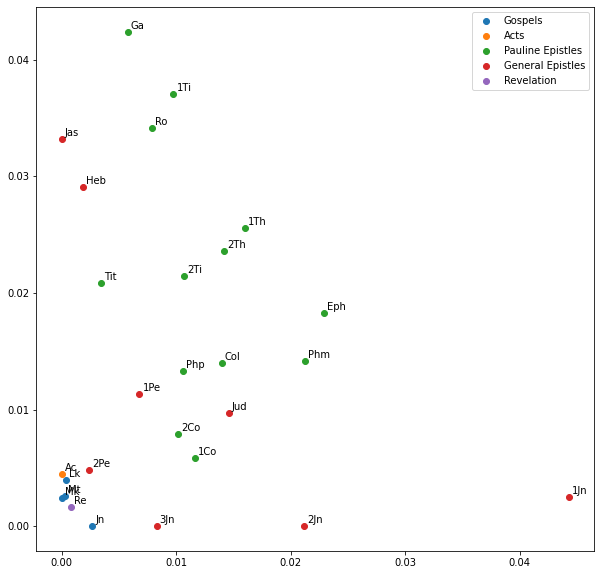

In [14]:
labels = [("Gospels", 0, 4), ("Acts", 4, 5), ("Pauline Epistles", 5, 18), ("General Epistles", 18, 26), ("Revelation", 26, 27)]
    
x = vec_norm[1476] # ἀγάπη
y = vec_norm[725] # πίστις

fig, ax = plt.subplots(figsize=(10, 10))

for (label, i, j) in labels:
    ax.plot(x[i:j], y[i:j], marker='o', linestyle='', label=label)

for i in range(len(books)):
    ax.annotate(books[i], (x[i], y[i]), xytext=(0.3, 0.3), textcoords="offset fontsize")

ax.legend()
plt.show()

On the x-axis we have plotted the normalized tf-idf score for the word ἀγάπη (love) for each book and on the y-axis we have plotted the normalized tf-idf score for the word πίστις (faith) for each book.

We can see that 1 John talks about love a lot, but not a lot about faith. On the other hand, Galatians talks a lot about faith but not a lot about love. And then we see the gospels, Acts, and Revelation bunched up in the bottom left corner that don't talk about love or faith a lot. Part of the reason why those books have such a low score is because they are quite long, and so even if they do talk about love or faith it ends up being a small percentage of the words used in the book.

This is an alright way to do dimensionality reduction, but it's also very subjective and arbitrary. Why did I pick those two words ἀγάπη and πίστις to look at? Because I knew already that they might be important features to look at. But what if there are important features in the data that I don't already know about? What if I want a more objective way to perform dimensionality reduction?

The solution to this is [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA), which performs dimensionality reduction on a high-dimensional dataset without any external input as to what features might be important. In our case, it will identify components as combinations of words (like five times ἀγάπη minus three times πίστις) that provide the highest variation in the data points, which are the books. The component which provides the greatest variation is called the principal component, but the analysis also generates a secondary component which provides the second greatest amount of variation, and so on.

Since we only have 27 data points corresponding to the 27 books in the New Testament within our 5,461-dimensional space of words, the maximum number of components that PCA can identify will be 27, but in practice we will actually care about far fewer.

In [15]:
pca = PCA(n_components=27)
vec_transform = pca.fit_transform(vec_norm.T)

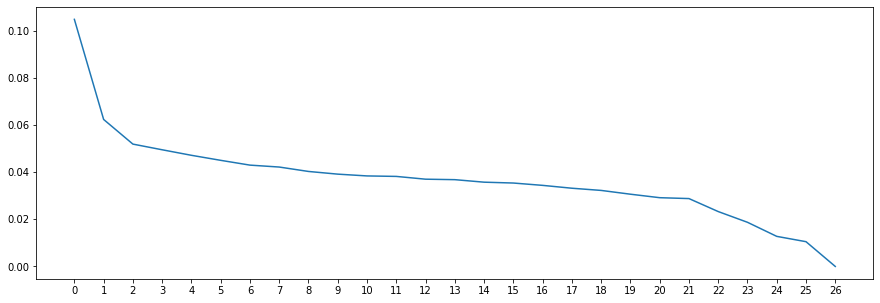

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(pca.explained_variance_ratio_)
plt.xticks(np.arange(0, 27))
plt.show()

The above plot shows the "explained variance ratio" of each of the 27 generated components from PCA. Together these all add up to 1, meaning that all of them together give all of the variance in the data.

Looking at just the 1st component, we see that it provides roughly 10% of the variance in the data. The second component provides roughly 6% of the variance (the first two components together would provide 16%) and so on.

The general rule of thumb is that you should stop looking at components once you get to the "elbow" in the above graph. That means the first three components might be helpful to look at, but we probably won't find it very meaningful to look at the fourth component and beyond.

We could redo the PCA with `n_components=3` but the three components we want to look at it are already included within the 27 so we don't need to.

In [17]:
# Plots the 27 data points with respect to component a on the x-axis and component b on the y-axis
def plotComponents(a, b):
    labels = [("Gospels", 0, 4), ("Acts", 4, 5), ("Pauline Epistles", 5, 18), ("General Epistles", 18, 26), ("Revelation", 26, 27)]
    
    x = vec_transform[:,a]
    y = vec_transform[:,b]

    fig, ax = plt.subplots(figsize=(10, 10))
    
    for (label, i, j) in labels:
        ax.plot(x[i:j], y[i:j], marker='o', linestyle='', label=label)

    for i in range(len(books)):
        ax.annotate(books[i], (x[i], y[i]), xytext=(0.3, 0.3), textcoords="offset fontsize")
    
    ax.legend()
    plt.show()

# Lists the top num words that contribute to component idx
def topFeatures(idx, num):
    args = np.argsort(np.abs(pca.components_[idx]))
    print("Component", idx + 1)
    for i in range(num):
        print(pca.components_[idx][args[-i-1]], words[args[-i-1]])

After defining some helpful functions, we can plot each of the 27 books with respect to the principal component on the x-axis and the secondary component on the y-axis.

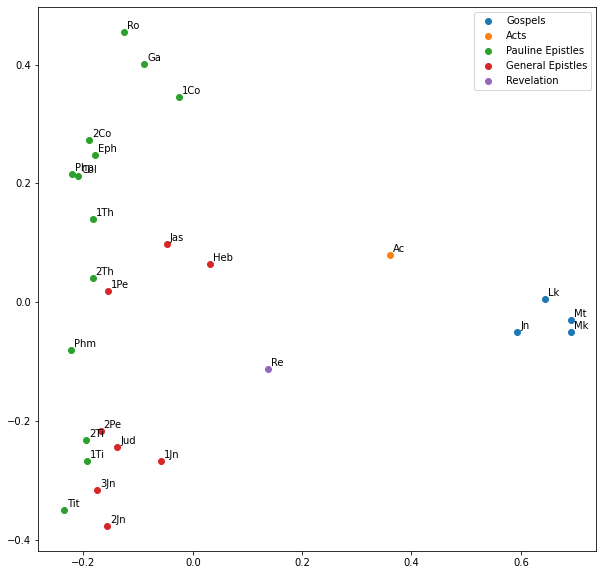

In [18]:
plotComponents(0, 1)

I've included different colors for the points based on their standard categorization within the New Testament and notice that the first and second component seem to mostly separate the books based on these categories quite nicely. Granted there is some close mixing between some of the Pauline epistles and the general epistles, but this separation all happened naturally from the math without us having to specify that these categories were important.

Looking at the principal component (the x-axis) we can see that it clearly separates the gospels from all the other books, with Acts and Revelation sitting in-between. We might call this the "Gospel component", and this is what the math identified as the most important feature which distinguishes books in the New Testament.

Every component, including the principal component, is just a weighted sum of all 5,461 unique words in the New Testament. Some words it gives a large positive weight towards (these are very Gospel-ey words), some words it gives a large negative weight towards (these are very un-Gospel-ey words), and some words it gives a small weight towards, either positive or negative (these are words which have no effect on how Gospel-ey a book is).

It was obvious from the plot that the principal component is measuring Gospel-ness, but by looking at which words have the highest absolute weight we can get an idea of how exactly it measures Gospel-ness.

In [19]:
topFeatures(0, 10)

Component 1
0.3568148554893001 μαθητής
0.24618967113224685 ἀποκρίνομαι
0.21023638843859999 ὄχλος
0.13841288687093467 Ἰωάννης
0.12630184671800798 εἰσέρχομαι
0.12552202078187893 ἀρχιερεύς
0.12203958043523218 Πέτρος
0.11663832603119653 λέγω
0.11027701223560346 Φαρισαῖος
0.10068520441720187 ἀφίημι


Here is the transliteration and English translation for these ten Greek words.

| Greek | (Transliteration) English |
| :--- | :--- |
| μαθητής | (mathetes) disciple |
| ἀποκρίνομαι | (apokrinomai) to answer |
| ὄχλος | (ochlos) crowd |
| Ἰωάννης | (Ioannes) John |
| εἰσέρχομαι | (eiserchomai) to enter |
| ἀρχιερεύς | (archiereus) chief priest |
| Πέτρος | (Petros) Peter |
| λέγω | (lego) to say |
| Φαρισαῖος | (Pharisaios) Pharisee |
| ἀφίημι | (aphiemi) to leave |

There are a few words here that make sense as coming from the Gospels, such as disciple, crowd, John, chief priest, Peter, and Pharisee. But then the other words show up because the Gospels are structured as narratives and so people do a lot of answering, entering, speaking, and leaving.

With these words we can conclude that Acts and Revelation show up so highly on the principal component because they are narrative-centered. Some of the keywords like crowd or chief priest might not get mentioned very often, but there are still lots of people answering, entering, speaking, and leaving.

We can also see that since Hebrews uses the term "chief priest" a lot, it ends up higher on the principal component, possibly also due to other words as well.

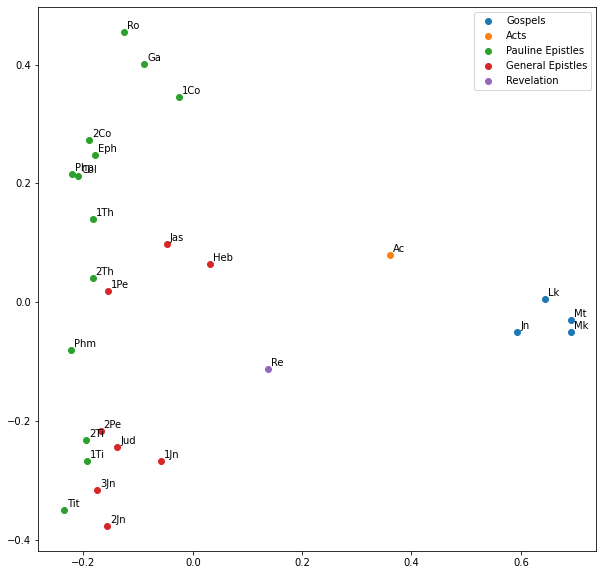

In [20]:
plotComponents(0, 1)

I've repeated the above plot so that you do not have to scroll up to see it.

Looking now at the second component, which is the y-axis, we can see that it does not differentiate the Gospels very much but that it seems to produce a wide spread in the epistles. Romans, Galatians, and 1 Corinthians are ranked highly while 2 John, 3 John, and Titus are ranked low. Just from looking at the graph, my first guess would be that this is separating more theologically dense epistles from the more pastoral epistles.

However, Hebrews is quite theologically dense but is middle of the pack for the second component. Similarly 1 John contains a lot of theology, but it definitely discusses different theological topics from what Paul often discusses in his letters. We cannot always necessarily assign every component to one neat human idea. Even the idea that the principal component was measuring Gospel-ness is just subjective.

Let's look at what words the second component is assigning the most weight to.

In [21]:
topFeatures(1, 10)

Component 2
0.28924694290242825 νόμος
-0.15426843907856397 κυρία
0.14892245917631072 εἴτε
-0.10108202193589903 ἀντίχριστος
-0.10093387016551617 ἐπιδέχομαι
0.10025503581172658 καυχάομαι
-0.09636137548068743 ὑγιαίνω
0.09578471197800936 μέλος
0.09378217857098288 περιτομή
-0.09185886077113116 πλάνος


Again I will provide a transliteration and translation for each word.

| Greek | (Transliteration) English |
| :--- | :--- |
| νόμος | (nomos) law |
| **κυρία** | **(kuria) lady (lord, feminine)** |
| εἴτε | (eite) if |
| **ἀντίχριστος** | **(antichristos) antichrist** |
| **ἐπιδέχομαι** | **(epidechomai) to receive hospitality** |
| καυχάομαι | (kauchaomai) to glory, boast, rejoice |
| **ὑγιαίνω** | **(hugiaino) to be well** |
| μέλος | (melos) member of the body |
| περιτομή | (peritome) circumcision |
| **πλάνος** | **(planos) deceiver** |

Notice that unlike the principal component, some of the weights for the second component happen to be negative. That means these words contribute to a book being rated lowly in the second component. I have bolded the negative weight words in the table as a reminder.

We can see that the second component positively weights books that talk about the law and circumcision, as well as use the word "if". All of these are particularly common in Paul's more theologically dense epistles and explains why they show up so highly.

The ideas of receiving hospitality and being well certainly seem to be reasonable words to identify epistles that are more pastoral and less theologically complex, but the other negatively weighted words in the second component, lady, antichrist, and deceiver, are not very clear.

The problem is that these words are very rare within the New Testament. "Lady" only appears in 2 John, "antichrist" only appears in 1 John and 2 John, and "deceiver" only appears once each in Matthew, 2 Corinthians, 1 Timothy, and 2 John. Because books like 2 John are so short, the tf-idf score for words that appear only in that book, like "lady", are very high. These words then get weighted highly in the components because they neatly separate out those books, increasing variation.

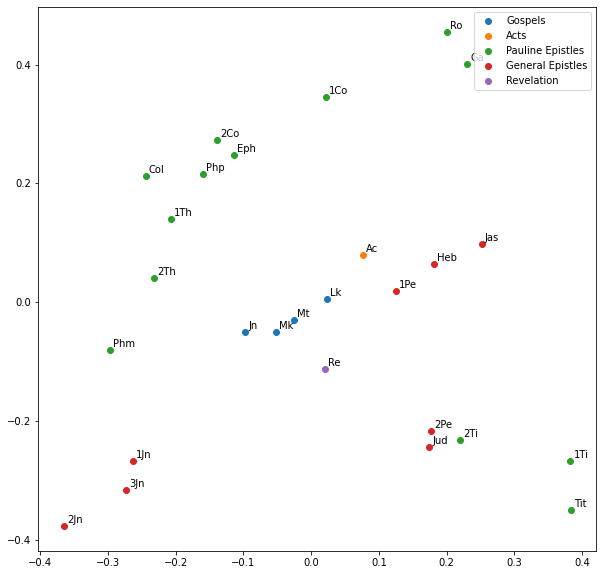

In [22]:
plotComponents(2, 1)

In this plot, the y-axis is the same as the previous plot, still the second component. But I have changed the x-axis from the principal component to the third component. This is the last component we will look at since the elbow in our plot of explained variance occured at this point.

It is difficult to determine some simple and meaningful metric that this third component might be measuring, so I will not say too much about it. It is interesting however that we get nice clustering of 1 John, 2 John, and 3 John as well as the clustering of Paul's pastoral epistles on the bottom right.

I will include the list of the top ten weighted words for the second component below without dicussion.

In [23]:
topFeatures(2, 10)

Component 3
0.19783235409820546 νόμος
-0.17929069419812094 κυρία
-0.11805760462751216 ἀντίχριστος
0.11423568542244551 εὐσέβεια
0.10646324726801448 διδασκαλία
-0.10468581216818494 ἐπιδέχομαι
-0.0970806508154875 μέλαν
-0.09606435324451212 πλάνος
-0.09124138957353324 μένω
-0.08964534709906047 χάρτης


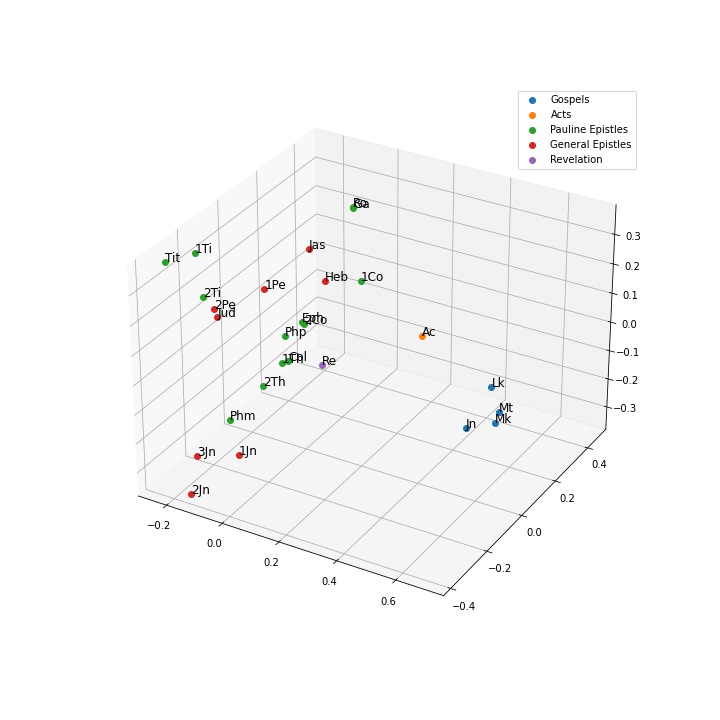

In [24]:
%matplotlib widget

labels = [("Gospels", 0, 4), ("Acts", 4, 5), ("Pauline Epistles", 5, 18), ("General Epistles", 18, 26), ("Revelation", 26, 27)]
    
x = vec_transform[:,0]
y = vec_transform[:,1]
z = vec_transform[:,2]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

for (label, i, j) in labels:
    ax.plot(x[i:j], y[i:j], z[i:j], marker='o', linestyle='', label=label)

for i in range(len(books)):
    ax.text(x[i], y[i], z[i], books[i], size=12)

ax.legend()
plt.show()

Here we have a 3D plot of each of the books with respect to our first three components. In the Jupyter notebook we can rotate the plot around and see how the different books cluster within the 3D space, but within the webpage it will not be interactive. 

This was one of the main goals of doing PCA in the first place. We had these points located in a 5,461-dimensional space that we can now visualize in a 3D space in the "best" way possible.

## Conclusion

Both the cosine similarity and the principal component analysis gave results that aligned with the way that we subjectively classify and compare the books in the New Testament. Even after reducing to three dimensions, the Gospels, the Johannine epistles, Paul's pastoral epistles, and the other Pauline epistles all formed clearly separated clusters.

One problem arose from the drastic difference in length between some of the books in the New Testament, with books like 2 John having single words that contributed strongly to their location. This combined with the fact that there are only 27 books total meant that the first three components from PCA had limited ability to explain much of the variation within the data. One solution to this may be to consider every chapter within the New Testament individually so that they're lengths would have greater similarity, we would have more granularity in examining topics within longer books, and we would have more data points for our analysis.

Another limitation is that the tf-idf method does not take into account word order or context, only what words are present and with what frequency. It would be interesting to explore some way of measuring text similarity that takes into account word order or measuring syntactic similarity via the grammar while ignoring the meaning of the actual words. It is, however, non-trivial to find a way to do this effectively.